# 互评作业3：分类、预测与聚类

**姓名**：杨毅哲

**学号**：3120201088

**GitHub**：https://github.com/YangPatrick/DataMining

## 包引用

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

## 数据处理

对数据进行加载，并对其情况进行简要展示后，进行数据预处理

In [2]:
data = pd.read_csv('hotel_bookings.csv')
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
data.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

从上面的数据可以看出，只有`children`，`country`，`agent`和`company`四个属性存在空值，但是在之后的数据挖掘任务中并不需要这四个属性，因此我们先将这些属性去除，避免影响之后分析

In [5]:
data = data.drop(['children', 'country', 'agent', 'company'], axis=1)

## 基本情况

目标：针对数据集，对城市酒店和假日酒店的预订需求和入住率进行比较

### 属性分析

首先我们先分析一下属性类型，分别分析`hotel`属性和`reservation_status`属性的取值

In [6]:
print(data['hotel'].unique())
print(data['reservation_status'].unique())

['Resort Hotel' 'City Hotel']
['Check-Out' 'Canceled' 'No-Show']


可见，数据集中只有两种`hotel`，分别是假日酒店（`Resort Hotel`）和城市酒店（`City Hotel`），而他们的预订状态有三种，分别是退房（`Check-Out`）、失约（`No-Show`）和取消预订（`Canceled`）。

我们以三种属性的总量作为预订需求的衡量值，而以退房属性的数量与总预订量的比率作为实际入住率。

In [7]:
print('Total Reservation')
reservation = data.hotel.value_counts()
print('City Hotel\t', reservation[0])
print('Resort Hotel\t', reservation[1])
check_out = data.loc[data['reservation_status']=='Check-Out'].hotel.value_counts()
print('Total Occupancy')
print('City Hotel\t', check_out[0])
print('Resort Hotel\t', check_out[1])
print('Occupancy Rate')
print('City Hotel\t',check_out[0]/reservation[0])
print('Resort Hotel\t',check_out[1]/reservation[1])

Total Reservation
City Hotel	 79330
Resort Hotel	 40060
Total Occupancy
City Hotel	 46228
Resort Hotel	 28938
Occupancy Rate
City Hotel	 0.5827303668221354
Resort Hotel	 0.7223664503245132


可以看出，虽然预订数量和入住数量上城市酒店都比假日酒店多，但是实际入住率假日酒店要比城市酒店多出14%，因此针对入住情况而言，假日酒店要好于城市酒店

## 用户行为分析

分析用户提前预定时间、入住时长、预订间隔以及餐食预订情况。

首先为了复用性，定义一个数据可视化函数：

In [8]:
def plotHist(data, col_name):
    plt.plot()
    data = data[col_name]
    plt.hist(data)
    plt.title(col_name)
    plt.show()

### 提前预定时间和预订间隔

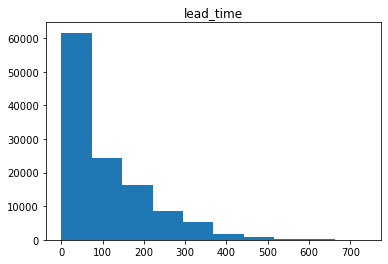

In [9]:
attribute_name = 'lead_time'
plotHist(data, attribute_name)

从上图可以看出，大部分情况都集中在提前200天预订，其中提前一天预订的数量最多
### 入住时长

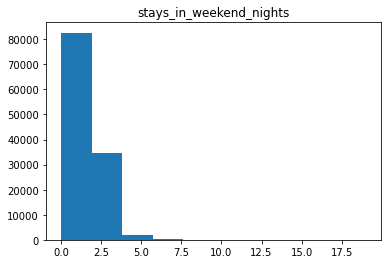

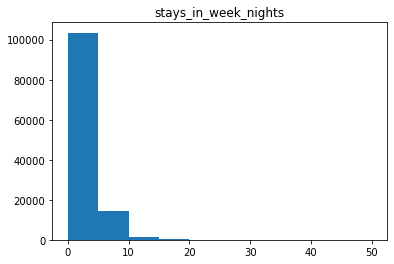

In [10]:
attribute_name = 'stays_in_weekend_nights'
plotHist(data, attribute_name)
attribute_name = 'stays_in_week_nights'
plotHist(data, attribute_name)

从上面两幅图像看出，大部分人的入住时间都是在一周以内的

### 餐食预订

由于餐食的属性值记录的是点餐食的类别，因此使用统计方法展示，定义统计可视化图函数：

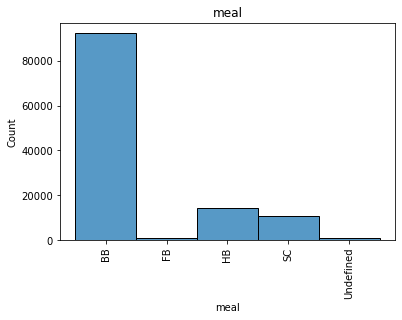

In [11]:
def plotCount(data, col_name):
    plt.plot()
    sns.histplot(data=data[col_name],stat='count')
    plt.title(col_name)
    plt.xticks(rotation=90)
    plt.show()
plotCount(data, 'meal')

从上图可以看出，点BB类餐的人数最多，而点FB类餐的人数最少。

## 一年中最佳预订酒店时间

本部分从最佳预订的月份、周数和日期的角度进行分析，寻找最佳预订时间。

首先分析每个月的预订数量：

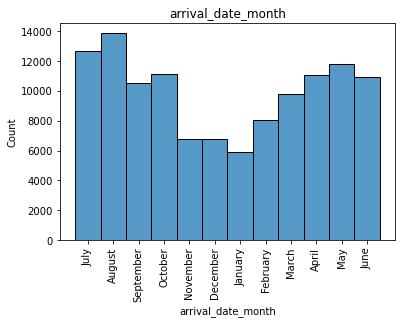

In [12]:
plotCount(data, 'arrival_date_month')

需要注意的是，上图的横轴并不是按照月份顺序进行排列的。从上图可以看出，六月份到八月份的到达人数最多，说明是入住的旺季。如果希望有房间，那么可以选择在十一月到二月预订。

其次是进行周数分析：

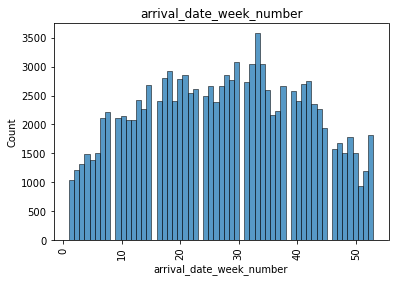

In [13]:
plotCount(data, 'arrival_date_week_number')

从上图可以看出，大多数的达到人数在几种在25到35周，进一步验证了在6到8月人数较多的分析结果。

最后是月份日期的分析：

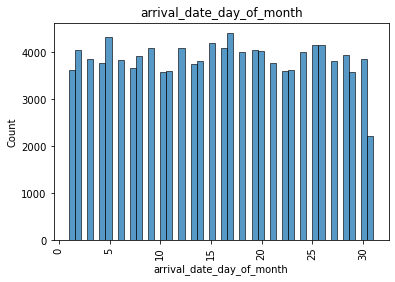

In [14]:
plotCount(data, 'arrival_date_day_of_month')

从上图可以看出，在月份中，每天到达的人数都差不多，因此不存在特别突出的分析价值。

## 利用Logistic预测酒店预订

为了进行Logistic预测，我们首先要将所有的标称属性重新编码为数值属性，才能作为特征进行预测，我们采用`sklearn`包中的`LabelEncoder`进行自动编码

In [15]:
label_encoder = LabelEncoder()
nominal_attribute_names = [
    'hotel',
    'customer_type',
    'assigned_room_type',
    'deposit_type',
    'reservation_status',
    'meal',
    'arrival_date_month',
    'distribution_channel',
    'market_segment',
    'reserved_room_type',
    'reservation_status_date'
]
for attribute_name in nominal_attribute_names:
    data[attribute_name] = label_encoder.fit_transform(data[attribute_name])

以酒店预订的最终状态`reservation_status`作为预测对象，其他属性作为特征输入，构建Logistic模型

In [16]:
X = data.drop(['reservation_status'], axis=1)
y = data['reservation_status']

按照机器学习的惯例，以8:2的比例划分训练集和测试集

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

使用Logistic模型进行拟合，对`reservation_status`属性值进行预测，并通过各类评价指标对结果进行分析

In [18]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Absolute Error: 0.25617723427422734
Mean Squared Error: 0.25835497110310746
R2 Score: -0.038809321385217865
